In [1]:
import os
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as torchvision_T
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


RESnet 50

In [3]:
def order_points(pts):
    # Initialiser un tableau pour stocker les coins ordonnés
    rect = np.zeros((4, 2), dtype="float32")
    # Convertir les points d'entrée en un tableau numpy
    pts = np.array(pts)
    # Calculer la somme des coordonnées x et y de chaque point
    s = pts.sum(axis=1)
    # Trouver les coins supérieur gauche et inférieur droit en utilisant l'indice de somme minimale et maximale
    rect[0] = pts[np.argmin(s)]  # Coin supérieur gauche
    rect[2] = pts[np.argmax(s)]  # Coin inférieur droit

    # Calculer la différence des coordonnées x et y de chaque point
    diff = np.diff(pts, axis=1)
    # Trouver les coins supérieur droit et inférieur gauche en utilisant l'indice de différence minimale et maximale
    rect[1] = pts[np.argmin(diff)]  # Coin supérieur droit
    rect[3] = pts[np.argmax(diff)]  # Coin inférieur gauche
    # Convertir les coordonnées en entiers et les retourner sous forme de liste
    return rect.astype("int").tolist()



def find_dest(pts):
    # Désigner les coins du quadrilatère (coins du rectangle) à partir des points d'entrée
    (tl, tr, br, bl) = pts

    # Calculer les longueurs des côtés du rectangle
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Créer les coins de destination cible en fonction des longueurs calculées
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    # Ordonner les coins de destination et les retourner
    return order_points(destination_corners)


In [4]:
def image_preproces_transforms(
    mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)
):
    common_transforms = torchvision_T.Compose(
        [torchvision_T.ToTensor(), torchvision_T.Normalize(mean, std),]
    )

    return common_transforms


"""La fonction load_model charge un modèle de segmentation d'image """
def load_model(num_classes=1, checkpoint_path=None, device=None):
    model = deeplabv3_resnet50(num_classes=num_classes)
    model.to(device)
    checkpoints = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoints, strict=False)
    model.eval()

    _ = model(torch.randn((2, 3, 384, 384)))

    return model


In [10]:
CHECKPOINT_MODEL_PATH = r"/content/model_r50_iou_mix_2C020 (1).pth"
# Chargement du modèle MobileNetV3-Large avec 2 classes depuis le point de contrôle
trained_model = load_model(num_classes=2, checkpoint_path=CHECKPOINT_MODEL_PATH, device=device)
preprocess_transforms = image_preproces_transforms()

In [5]:
def extract(image_true=None, trained_model=None, image_size=384, BUFFER=10):
    global preprocess_transforms

    IMAGE_SIZE = image_size
    half = IMAGE_SIZE // 2

    imH, imW, C = image_true.shape

    image_model = cv2.resize(image_true, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    scale_x = imW / IMAGE_SIZE
    scale_y = imH / IMAGE_SIZE

    image_model = preprocess_transforms(image_model)
    image_model = torch.unsqueeze(image_model, dim=0)

    with torch.no_grad():
        out = trained_model(image_model)["out"].cpu()

    del image_model
    gc.collect()

    out = torch.argmax(out, dim=1, keepdims=True).permute(0, 2, 3, 1)[0].numpy().squeeze().astype(np.int32)
    r_H, r_W = out.shape

    _out_extended = np.zeros((IMAGE_SIZE + r_H, IMAGE_SIZE + r_W), dtype=out.dtype)
    _out_extended[half : half + IMAGE_SIZE, half : half + IMAGE_SIZE] = out * 255
    out = _out_extended.copy()

    del _out_extended
    gc.collect()

    # Edge Detection.
    canny = cv2.Canny(out.astype(np.uint8), 225, 255)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # ==========================================
    epsilon = 0.02 * cv2.arcLength(page, True)
    corners = cv2.approxPolyDP(page, epsilon, True)

    corners = np.concatenate(corners).astype(np.float32)

    corners[:, 0] -= half
    corners[:, 1] -= half

    corners[:, 0] *= scale_x
    corners[:, 1] *= scale_y

    # check if corners are inside.
    # if not find smallest enclosing box, expand_image then extract document
    # else extract document

    if not (np.all(corners.min(axis=0) >= (0, 0)) and np.all(corners.max(axis=0) <= (imW, imH))):

        left_pad, top_pad, right_pad, bottom_pad = 0, 0, 0, 0

        rect = cv2.minAreaRect(corners.reshape((-1, 1, 2)))
        box = cv2.boxPoints(rect)
        box_corners = np.int32(box)
        #     box_corners = minimum_bounding_rectangle(corners)

        box_x_min = np.min(box_corners[:, 0])
        box_x_max = np.max(box_corners[:, 0])
        box_y_min = np.min(box_corners[:, 1])
        box_y_max = np.max(box_corners[:, 1])

        # Find corner point which doesn't satify the image constraint
        # and record the amount of shift required to make the box
        # corner satisfy the constraint
        if box_x_min <= 0:
            left_pad = abs(box_x_min) + BUFFER

        if box_x_max >= imW:
            right_pad = (box_x_max - imW) + BUFFER

        if box_y_min <= 0:
            top_pad = abs(box_y_min) + BUFFER

        if box_y_max >= imH:
            bottom_pad = (box_y_max - imH) + BUFFER

        # new image with additional zeros pixels
        image_extended = np.zeros((top_pad + bottom_pad + imH, left_pad + right_pad + imW, C), dtype=image_true.dtype)

        # adjust original image within the new 'image_extended'
        image_extended[top_pad : top_pad + imH, left_pad : left_pad + imW, :] = image_true
        image_extended = image_extended.astype(np.float32)

        # shifting 'box_corners' the required amount
        box_corners[:, 0] += left_pad
        box_corners[:, 1] += top_pad

        corners = box_corners
        image_true = image_extended

    corners = sorted(corners.tolist())
    corners = order_points(corners)
    destination_corners = find_dest(corners)
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))

    final = cv2.warpPerspective(image_true, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LANCZOS4)
    final = np.clip(final, a_min=0., a_max=255.)

    return final

The input image

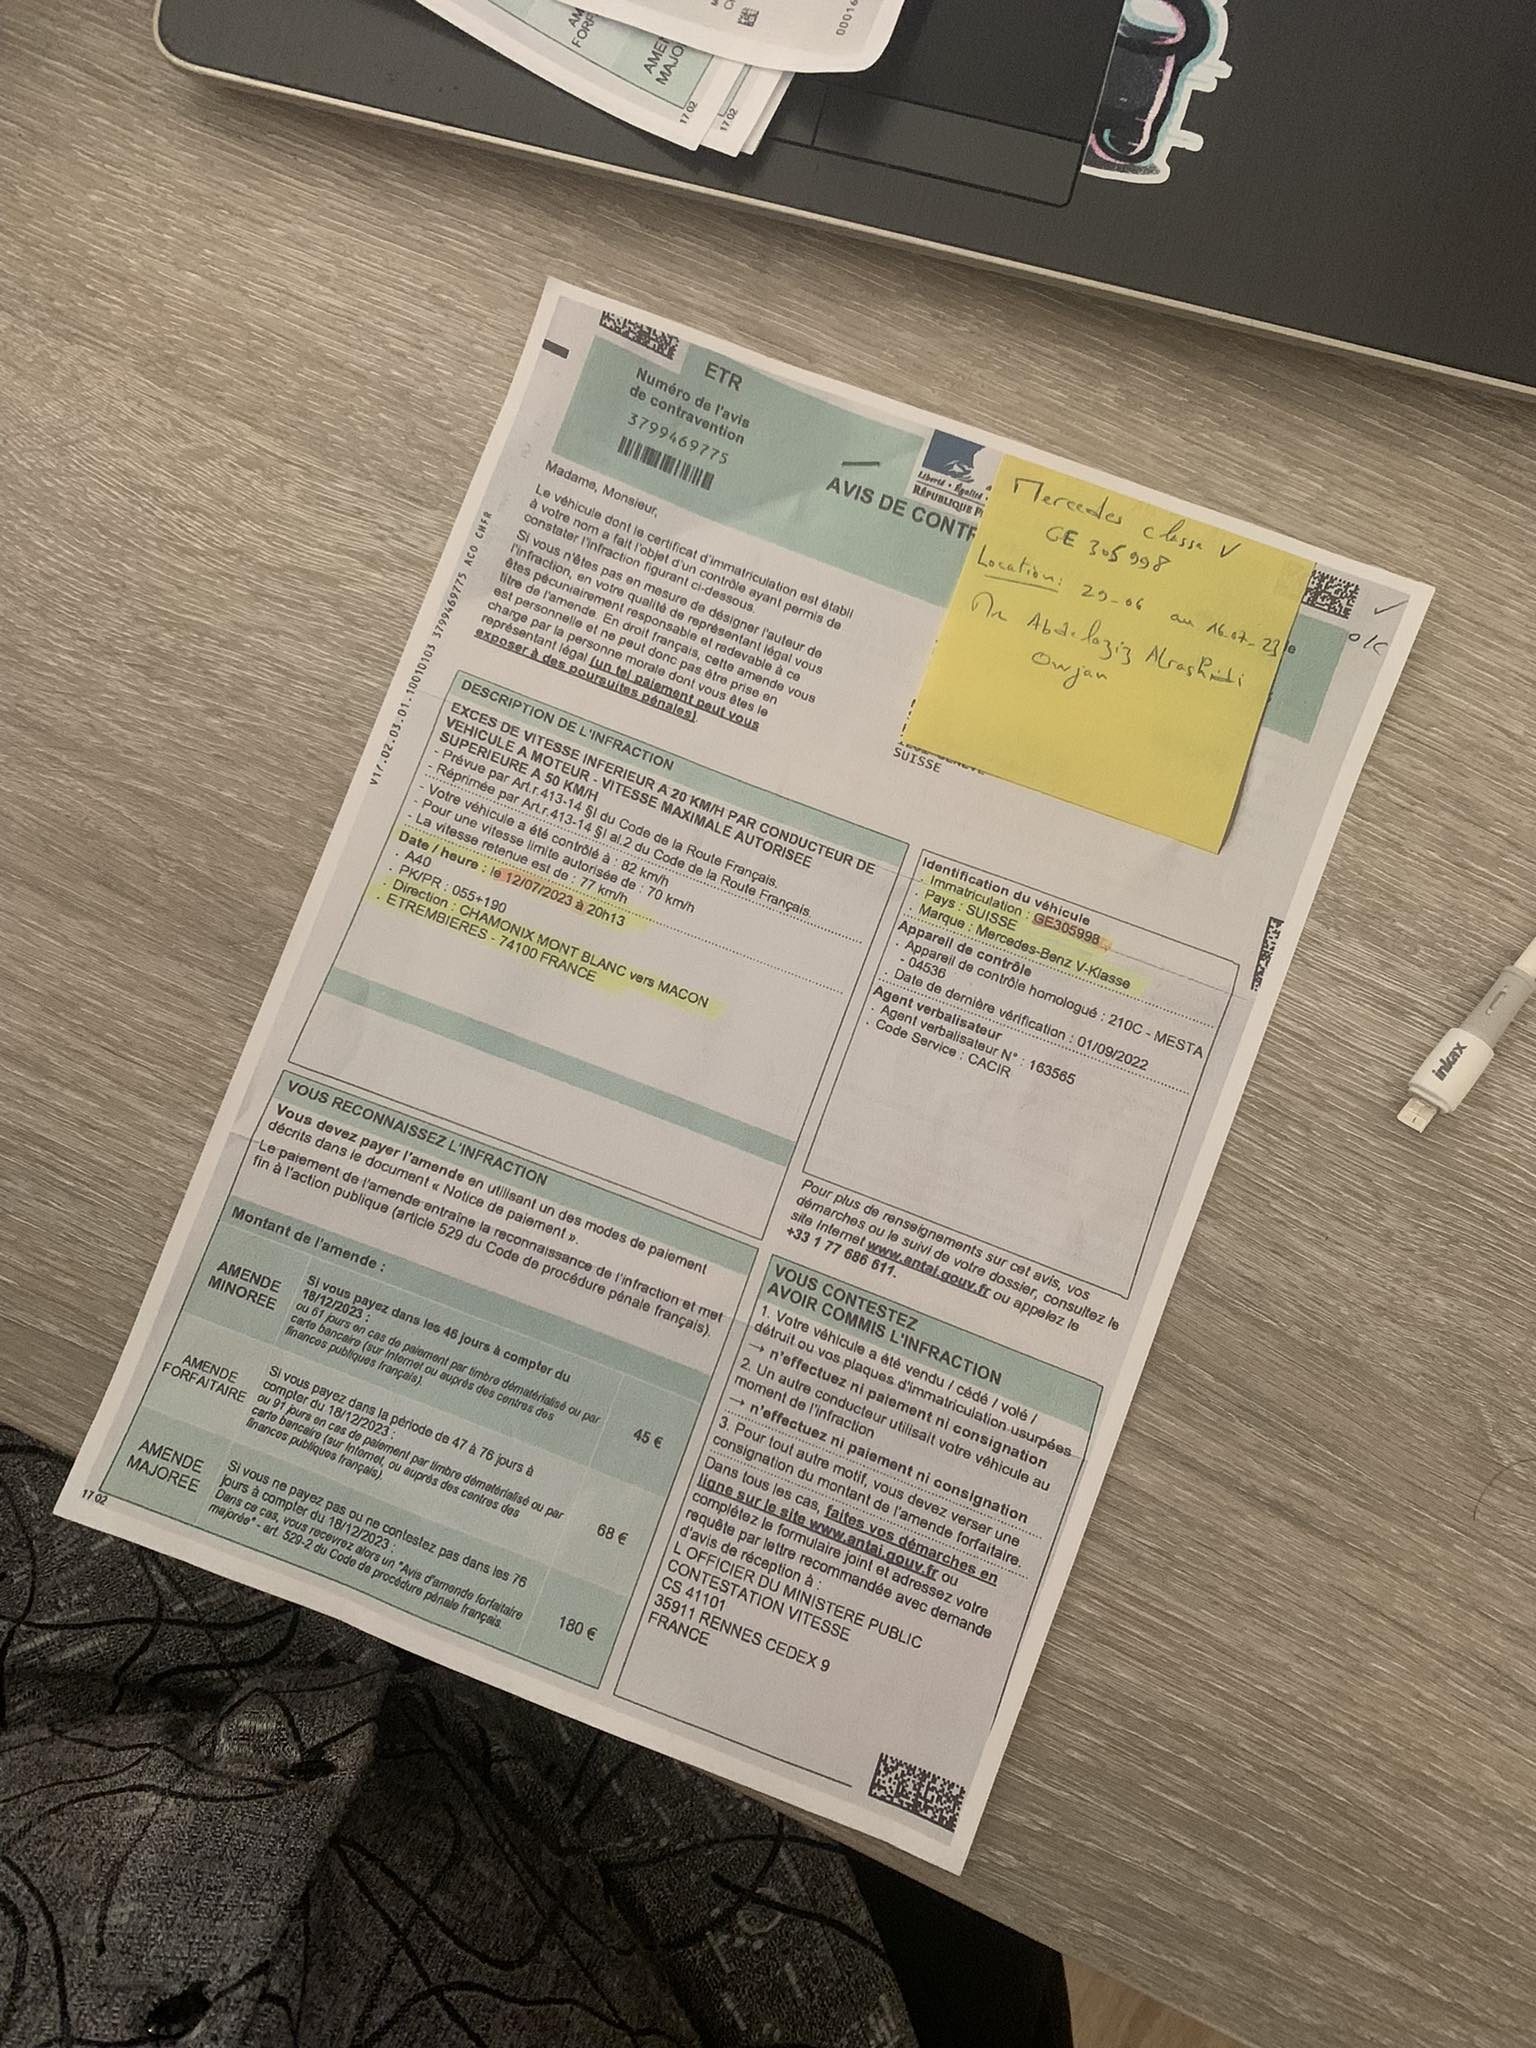

uint8


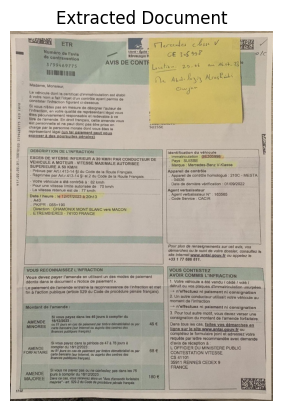

Extracted document saved at: /content/extracted_document_resnet50.jpg


In [50]:
import os
import cv2
import matplotlib.pyplot as plt

image_path = "/content/449696944_465965902808940_1179266765716337976_n.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1]
print(image.dtype)

document = extract(image_true=image, trained_model=trained_model)

plt.imshow(document / 255.0)
plt.title("Extracted Document")
plt.axis('off')
plt.show()

output_path = "/content/extracted_document_resnet50.jpg"
document_uint8 = (document).astype('uint8')
cv2.imwrite(output_path, document_uint8)

print(f"Extracted document saved at: {output_path}")


**AutoEncoders**

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 Conv1 (Conv2D)              (None, None, None, 128)   1280      
                                                                 
 BN1 (BatchNormalization)    (None, None, None, 128)   512       
                                                                 
 pool1 (MaxPooling2D)        (None, None, None, 128)   0         
                                                                 
 Conv2 (Conv2D)              (None, None, None, 128)   147584    
                                                                 
 upsample1 (UpSampling2D)    (None, None, None, 128)   0         
                                                                 
 Conv3 (Conv2D)              (None, None, None, 1)     1153

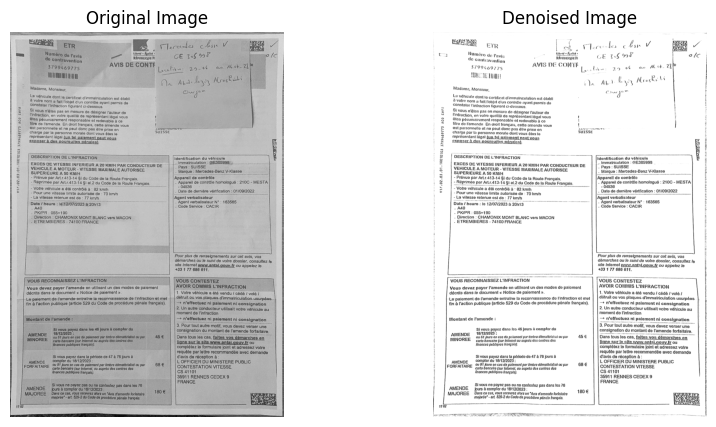

In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Input

# Assuming the model has already been trained as per your script
input_shape = (None, None, 1)

# Rebuild the model using functional API
inputs = Input(shape=input_shape)

# Encoder
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv1')(inputs)
x = BatchNormalization(name='BN1')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)

# Decoder
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv2')(x)
x = UpSampling2D((2, 2), name='upsample1')(x)
outputs = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Conv3')(x)

model = Model(inputs, outputs)
model.summary()

# Load the weights from the previously trained model
model.load_weights('denoising_autoencoder_80.h5')

# Function to preprocess a new image while keeping the original size
def preprocess_image(image_path):
    img = cv2.imread(image_path, 0)  # Load the image in grayscale
    img = img / 255.  # Normalize the pixel values
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to denoise a single image
def denoise_single_image(image_path):
    preprocessed_image = preprocess_image(image_path)

    # Make a prediction on the new image
    denoised_image = model.predict(preprocessed_image)

    # Remove the batch dimension and channel dimension for display
    denoised_image = np.squeeze(denoised_image)

    # Save the denoised image
    denoised_image_path = 'denoised_image.png'
    cv2.imwrite(denoised_image_path, denoised_image * 255)  # Convert back to 0-255 range and save

    print(f'Denoised image saved at: {denoised_image_path}')

    # Display the original and denoised images
    original_image = cv2.imread(image_path, 0)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Test the function on a single image
test_image_path = '/content/extracted_document_resnet50.jpg'  # Change this to the path of your test image
denoise_single_image(test_image_path)


OCR Space API

In [52]:
import requests
import json
def ocr_space_file(filename, overlay=False, api_key='K86107864288957', language='eng'):
    payload = {
        'isOverlayRequired': True,
        'apikey': api_key,
        'language': language,
        'detectOrientation':True,
        'scale':True,
        'OCREngine': 2
    }
    with open(filename, 'rb') as f:
        r = requests.post(
            'https://api.ocr.space/parse/image',
            files={filename: f},
            data=payload,
        )
    result = json.loads(r.content.decode())  # Convert JSON response to Python object
    if 'ParsedResults' in result and len(result['ParsedResults']) > 0:
        extracted_text = result['ParsedResults'][0]['ParsedText']  # Extract parsed text
        return extracted_text
    else:
        return "No text extracted or error occurred"

In [53]:
result_file = ocr_space_file(
                output_path,
                language='fre',  # Use 'fre' for French language
            )

In [54]:
result_file

'V17.02.03.01.10010103 3799469775 ACO CHFR\nETR\nNuméro de l\'avis\nde contravention\n3799469775\nRÉPUBLIQUE PI\nAVIS DE CONTE\nMadame, Monsieur,\nLe véhicule dont le certificat d\'immatriculation est établi\nà votre nom a fait l\'objet d\'un controle ayant permis de\nconstater l\'infraction figurant ci-dessous.\nSi vous n\'êtes pas en mesure de désigner l\'auteur de\nl\'infraction, en votre qualité de représentant légal vous\nêtes pécuniairement responsable et redevable à ce\ntitre de l\'amende. En droit français, cette amende vous\nest personnelle et ne peut donc pas être prise en\ncharge par la personne morale dont vous êtes le\nreprésentant légal (un tel paiement peut vous\nexposer à ses poursuites pénales)\nSUISSE\nDESCRIPTION DE L\'INFRACTION\nEXCES DE VITESSE INFERIEUR A 20 KM/H PAR CONDUCTEUR DE\nVEHICULE A MOTEUR - VITESSE MAXIMALE AUTORISEE\nSUPERIEURE A 50 KM/H\n- Prévue par Art.r. 413-14 §l du Code de la Route Français.\n- Réprimée par Art.r.413-14 §| al.2 du Code de la Rou